In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from os.path import join
from tqdm.notebook import tqdm
import os
from os.path import basename
import time
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from qmlhep.data_handling.dataset import ParticlePhysics
from qmlhep.config import processed_data_path, raw_data_path, signal_used, others_path
from qmlhep.utils.helper import get_features
from qmlhep.config import analisys_results_path
import pickle
from glob import glob
from qmlhep.qml.adam import AdamModel
from qmlhep.qml.optuna import OptunaModel
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# Remove warnings
import warnings
warnings.filterwarnings("ignore")


from sklearn.inspection import DecisionBoundaryDisplay

In [3]:
# Create dataframe for sns
df = pd.DataFrame()



for study in ["AdamModel", "OptunaModel"]:
    results = glob(join(analisys_results_path, study, f"*.pkl"))

    for result in tqdm(results):
        with open(result, "rb") as f:
            qml_worlds, svm_worlds, log_worlds = pickle.load(f)

        for i, qml_world in enumerate(qml_worlds):
            hp = qml_world


            qml_model = globals()[study](**hp)
            X_train, W_train, Y_train = qml_model.train_dataset.all_data()
            hp['X_train'] = X_train
            hp['W_train'] = W_train
            hp['Y_train'] = Y_train


            hp["model"] = "QML"
            hp["run"] = i
            hp["name"] = int(hp["name"].split("_")[0])
            hp["auc_val"] = roc_auc_score(hp["Y_val"], hp["Y_val_scores"], sample_weight=hp["W_val"])
            hp["auc_test"] = roc_auc_score(hp["Y_test"], hp["Y_test_scores"], sample_weight=hp["W_test"])

            # Infer model on train 
            weights = qml_model.load_model()
            hp["Y_train_scores"] = np.array([qml_model.classifier(weights, x) for x in hp["X_train"]])

            # Add auc train
            hp["auc_train"] = roc_auc_score(hp["Y_train"], hp["Y_train_scores"], sample_weight=hp["W_train"])

            df = pd.concat([df, pd.DataFrame.from_dict(hp, orient="index").T])

        for i, svm_world in enumerate(svm_worlds):
            hp = svm_world

            qml_model = globals()[study](**hp)
            X_train, W_train, Y_train = qml_model.train_dataset.all_data()
            hp['X_train'] = X_train
            hp['W_train'] = W_train
            hp['Y_train'] = Y_train

            hp["model"] = "SVM"
            hp["run"] = i
            hp["name"] = int(hp["name"].split("_")[0])
            hp["auc_val"] = roc_auc_score(hp["Y_val"], hp["Y_val_scores"], sample_weight=hp["W_val"])
            hp["auc_test"] = roc_auc_score(hp["Y_test"], hp["Y_test_scores"], sample_weight=hp["W_test"])

            # Train model 
            clf = SVC(kernel='rbf', probability=True, random_state=0)
            clf.fit(hp["X_train"], hp["Y_train"], sample_weight=hp["W_train"])

            # AUC train
            hp["Y_train_scores"] = clf.predict_proba(hp["X_train"])[:, 1]
            hp["auc_train"] = roc_auc_score(hp["Y_train"], hp["Y_train_scores"], sample_weight=hp["W_train"])

            df = pd.concat([df, pd.DataFrame.from_dict(hp, orient="index").T])

        for i, log_world in enumerate(log_worlds):
            hp = log_world

            qml_model = globals()[study](**hp)
            X_train, W_train, Y_train = qml_model.train_dataset.all_data()
            hp['X_train'] = X_train
            hp['W_train'] = W_train
            hp['Y_train'] = Y_train

            hp["model"] = "LR"
            hp["run"] = i
            hp["name"] = int(hp["name"].split("_")[0])
            hp["auc_val"] = roc_auc_score(hp["Y_val"], hp["Y_val_scores"], sample_weight=hp["W_val"])
            hp["auc_test"] = roc_auc_score(hp["Y_test"], hp["Y_test_scores"], sample_weight=hp["W_test"])

            # Train model
            clf = LogisticRegression(random_state=0)
            clf.fit(hp["X_train"], hp["Y_train"], sample_weight=hp["W_train"])

            # AUC train
            hp["Y_train_scores"] = clf.predict_proba(hp["X_train"])[:, 1]
            hp["auc_train"] = roc_auc_score(hp["Y_train"], hp["Y_train_scores"], sample_weight=hp["W_train"])


            df = pd.concat([df, pd.DataFrame.from_dict(hp, orient="index").T])

df.reset_index(inplace=True, drop=True)

# Infer
df = df.infer_objects()

# Rename columns
df.rename(
    columns={
        "study_name": "Study",
        "feature_method": "Feature Method",
        "n_datapoints": "#Datapoints",
        "auc": "AUC",
        "n_features": "#Features",
        "n_layers": "#Layers",
        "model": "Model",
    },
    inplace=True,
)
df.head(5)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Save df
df.to_csv("df.csv"), index=False)

In [3]:
# open df
df = pd.read_csv("violin.csv")
df

,Feature Method,#Datapoints,#Features,#Layers,max_epochs,learning_rate,Study,name,random_seed,X_val,...,Y_test_scores,X_train,W_train,Y_train,Model,run,auc_val,auc_test,Y_train_scores,auc_train
0,SBS,5000,2,4,500,0.03,AdamModel,108,2030606455,[[-2.62157393 -1.57079637]\n [-3.08019543 1.5...,...,[0.27700742 0.68996333 0.21179857 ... 0.136918...,[[ 0. -2.4546344]\n [-1.5707964 -2.7053...,[1.42631903e-08 1.42631903e-08 1.42631903e-08 ...,[1 1 1 ... 0 0 0],QML,0,0.811791,0.816682,[ 0.72220924 0.66228124 -0.73833586 ... -0.75...,0.397022
1,SBS,5000,2,4,500,0.03,AdamModel,108,163271720,[[-2.64148474 -1.57079637]\n [-1.38797343 0. ...,...,[0.1003863 0.15550903 0.1955959 ... 0.105377...,[[ 0. -2.7081995]\n [-1.5707964 -2.4986...,[1.42631903e-08 1.42631903e-08 1.42631903e-08 ...,[1 1 1 ... 0 0 0],QML,1,0.821478,0.811802,[0.75361941 0.66727382 0.72095795 ... 0.769863...,0.416854
2,SBS,5000,2,4,500,0.03,AdamModel,108,3518801104,[[-1.79201055 0. ]\n [-2.35311317 -3.14...,...,[0.31198159 0.24082638 0.27428603 ... 0.243310...,[[-3.1415927 -1.7973375]\n [-3.1415927 -2.9959...,[1.42631903e-08 1.42631903e-08 1.42631903e-08 ...,[1 1 1 ... 0 0 0],QML,2,0.809997,0.813220,[-0.70631843 -0.7622292 -0.77312486 ... 0.77...,0.420471
3,SBS,5000,2,4,500,0.03,AdamModel,108,387863003,[[-2.60283113 -1.57079637]\n [-2.09640718 -3.1...,...,[0.09717203 0.29140343 0.21329022 ... 0.147311...,[[ 0. -2.1462548]\n [-1.5707964 -2.8782...,[1.42631903e-08 1.42631903e-08 1.42631903e-08 ...,[1 1 1 ... 0 0 0],QML,3,0.808097,0.795885,[ 0.73402643 0.64744519 0.74292275 ... -0.76...,0.412336
4,SBS,5000,2,4,500,0.03,AdamModel,108,1081166937,[[-2.28530908 1.57079637]\n [-2.81786251 0. ...,...,[0.12567628 0.43396908 0.36480234 ... 0.334203...,[[ 1.5707964 -2.9775474]\n [-3.1415927 -2.3103...,[1.42631903e-08 1.42631903e-08 1.42631903e-08 ...,[1 1 1 ... 0 0 0],QML,4,0.818445,0.814554,[-0.59755955 -0.77173487 -0.78247077 ... -0.78...,0.415221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,PCA,500,3,2,500,0.03,OptunaModel,61,2030606455,[[ 0.43608177 0.93995583 1.4219226 ]\n [-0.7...,...,[0.60283487 0.9608927 0.50444413 0.50320022 0...,[[-1.6344311 -1.6540564 0.30365855]\n [-2.0...,[3.86525012 3.86525012 3.86525012 3.86525012 3...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,LR,0,0.811853,0.799928,[0.68965303 0.50840005 0.41211788 0.95529401 0...,0.758118
5996,PCA,500,3,2,500,0.03,OptunaModel,61,163271720,[[ 1.3105443e+00 7.5068059e+00 -1.3459202e+00...,...,[0.23447612 0.40572064 0.57177915 0.69677328 0...,[[-1.9206586 -1.4548641 0.42611936]\n [-1.6...,[3.86525012 3.86525012 3.86525012 3.86525012 3...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,LR,1,0.750108,0.748707,[0.63378633 0.91418459 0.8424664 0.41833757 0...,0.748922
5997,PCA,500,3,2,500,0.03,OptunaModel,61,3518801104,[[ 2.7478044 -0.31013328 -0.6459375 ]\n [ 1.2...,...,[0.69495925 0.59919388 0.7553926 0.52137734 0...,[[-0.9098774 -1.5639032 0.17070967]\n [-2.1...,[3.86525012 3.86525012 3.86525012 3.86525012 3...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,LR,2,0.810129,0.748455,[0.90769821 0.37287637 0.42279734 0.5743453 0...,0.735596
5998,PCA,500,3,2,500,0.03,OptunaModel,61,387863003,[[ 0.7154813 1.1947274 -1.3077762 ]\n [ 2.6...,...,[0.64656802 0.89011999 0.52768794 0.86819554 0...,[[-1.3104627e+00 -1.7963215e+00 4.6956442e-02...,[3.86525012 3.86525012 3.86525012 3.86525012 3...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,LR,3,0.737895,0.788398,[0.84702156 0.43582651 0.46328501 0.47034541 0...,0.792601


In [4]:
for model in df['Model'].unique():
    data = df[df["Model"] == model]
    print(data.shape)

(2000, 26)
(2000, 26)
(2000, 26)


In [5]:
df.columns

Index(['Feature Method', '#Datapoints', '#Features', '#Layers', 'max_epochs',
       'learning_rate', 'Study', 'name', 'random_seed', 'X_val', 'Y_val',
       'W_val', 'Y_val_scores', 'X_test', 'Y_test', 'W_test', 'Y_test_scores',
       'X_train', 'W_train', 'Y_train', 'Model', 'run', 'auc_val', 'auc_test',
       'Y_train_scores', 'auc_train'],
      dtype='object')

In [6]:
import seaborn as sns

sns.set_theme(style="whitegrid")

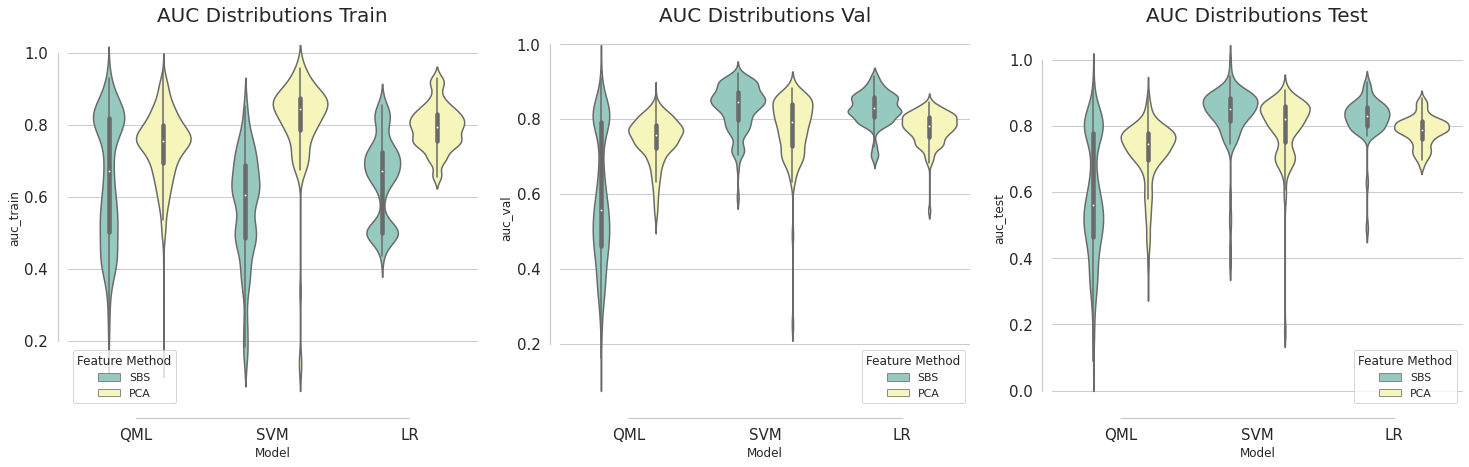

In [7]:
# Plot for train, val, test

# init figure
fig, ax = plt.subplots(1, 3, figsize=(25, 7))



for i, split in enumerate(["train", "val", "test"]):
    sns.violinplot(x="Model", y=f"auc_{split}", hue="Feature Method", data=df, palette="Set3", ax=ax[i])
    sns.despine(offset=10, trim=True)
    ax[i].set_title(f"AUC Distributions {split.capitalize()}", fontsize=20)

    # Biggify
    ax[i].tick_params(axis='both', which='major', labelsize=15)


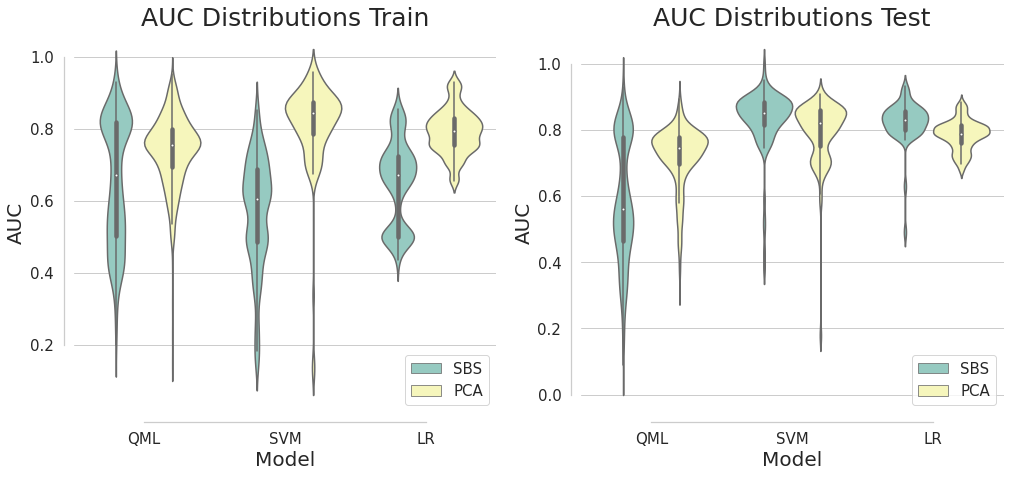

In [8]:
# Plot for train, val, test

# init figure
fig, ax = plt.subplots(1, 2, figsize=(25/3*2, 7))



for i, split in enumerate(["train", "test"]):
    a = sns.violinplot(x="Model", y=f"auc_{split}", hue="Feature Method", data=df, palette="Set3", ax=ax[i])

    sns.despine(offset=10, trim=True)

    # rename y axis
    a.axes.set_ylabel("AUC", fontsize=20)
    # rename x axis
    a.axes.set_xlabel("Model", fontsize=20)
    


    
    ax[i].set_title(f"AUC Distributions {split.capitalize()}", fontsize=25)

    # Biggify
    ax[i].tick_params(axis='both', which='major', labelsize=15)

    # Legend
    ax[i].legend(fontsize=15, loc="lower right")

# Set all x axis font size
for i in range(2):
    ax[i].tick_params(axis='x', which='major', labelsize=15)

#plt.tight_layout()
plt.show()